In [58]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import format_df, calculate_index, weight_domains
from scripts.utils.index_plot import index_plot, index_domain_plot

In [59]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/domain_standardized_data'

pull_csv_from_directory(bucket_name, aws_dir, search_zipped=False)

Saved DataFrame as 'built_index_data.csv'
Saved DataFrame as 'climate_products.csv'
Saved DataFrame as 'governance_index_data.csv'
Saved DataFrame as 'natural_index_data.csv'
Saved DataFrame as 'society_economy_index_data.csv'


In [76]:
built_domain = pd.read_csv('built_index_data.csv')
governance_domain = pd.read_csv('governance_index_data.csv')
natural_domain = pd.read_csv('natural_index_data.csv')
society_domain = pd.read_csv('society_economy_index_data.csv')
climate_domain = pd.read_csv('climate_products.csv')

In [61]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]

Next, we'll read in the synthetic climate indicator data as well, so we can calculate the Index across California. 

In [62]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

In [63]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Display the dataframe
merged_domains

,GEOID,summed_indicators_governance_domain_min_max_standardized,summed_indicators_built_domain_min_max_standardized,summed_indicators_natural_domain_min_max_standardized,summed_indicators_society_economy_domain_min_max_standardized
0,06001400100,0.471353,0.640031,0.417985,0.665240
1,06001400200,0.471353,0.588670,0.286363,0.658452
2,06001400300,0.471353,0.615958,0.681579,0.702919
3,06001400400,0.471353,0.625081,0.669441,0.727820
4,06001400500,0.471353,0.601230,0.618839,0.762025
...,...,...,...,...,...
9124,06115040902,0.536479,0.744755,0.626012,0.700578
9125,06115041001,0.536479,0.898643,0.629817,0.743486
9126,06115041002,0.536479,0.803379,0.318477,0.745345
9127,06115041101,0.536479,0.887591,0.253372,0.768845


In [64]:
merged_domains['built_median'] = merged_domains['summed_indicators_built_domain_min_max_standardized'].median()
merged_domains['governance_median'] = merged_domains['summed_indicators_governance_domain_min_max_standardized'].median()
merged_domains['natural_median'] = merged_domains['summed_indicators_natural_domain_min_max_standardized'].median()
merged_domains['society_economy_median'] = merged_domains['summed_indicators_society_economy_domain_min_max_standardized'].median()

merged_domains

,GEOID,summed_indicators_governance_domain_min_max_standardized,summed_indicators_built_domain_min_max_standardized,summed_indicators_natural_domain_min_max_standardized,summed_indicators_society_economy_domain_min_max_standardized,built_median,governance_median,natural_median,society_economy_median
0,06001400100,0.471353,0.640031,0.417985,0.665240,0.545107,0.465803,0.539009,0.757574
1,06001400200,0.471353,0.588670,0.286363,0.658452,0.545107,0.465803,0.539009,0.757574
2,06001400300,0.471353,0.615958,0.681579,0.702919,0.545107,0.465803,0.539009,0.757574
3,06001400400,0.471353,0.625081,0.669441,0.727820,0.545107,0.465803,0.539009,0.757574
4,06001400500,0.471353,0.601230,0.618839,0.762025,0.545107,0.465803,0.539009,0.757574
...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.536479,0.744755,0.626012,0.700578,0.545107,0.465803,0.539009,0.757574
9125,06115041001,0.536479,0.898643,0.629817,0.743486,0.545107,0.465803,0.539009,0.757574
9126,06115041002,0.536479,0.803379,0.318477,0.745345,0.545107,0.465803,0.539009,0.757574
9127,06115041101,0.536479,0.887591,0.253372,0.768845,0.545107,0.465803,0.539009,0.757574


In [65]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'summed_indicators_{category}_domain_min_max_standardized'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in merged_domains.iterrows():
    for category in ['natural', 'society_economy', 'built']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        merged_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
merged_domains

,GEOID,summed_indicators_governance_domain_min_max_standardized,summed_indicators_built_domain_min_max_standardized,summed_indicators_natural_domain_min_max_standardized,summed_indicators_society_economy_domain_min_max_standardized,built_median,governance_median,natural_median,society_economy_median,natural_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted
0,06001400100,0.471353,0.640031,0.417985,0.665240,0.545107,0.465803,0.539009,0.757574,-0.224531,-0.121881,0.174138
1,06001400200,0.471353,0.588670,0.286363,0.658452,0.545107,0.465803,0.539009,0.757574,-0.468723,-0.130841,0.079916
2,06001400300,0.471353,0.615958,0.681579,0.702919,0.545107,0.465803,0.539009,0.757574,0.264503,-0.072145,0.129976
3,06001400400,0.471353,0.625081,0.669441,0.727820,0.545107,0.465803,0.539009,0.757574,0.241984,-0.039275,0.146712
4,06001400500,0.471353,0.601230,0.618839,0.762025,0.545107,0.465803,0.539009,0.757574,0.148104,0.005876,0.102957
...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.536479,0.744755,0.626012,0.700578,0.545107,0.465803,0.539009,0.757574,0.161412,-0.075234,0.366253
9125,06115041001,0.536479,0.898643,0.629817,0.743486,0.545107,0.465803,0.539009,0.757574,0.168472,-0.018596,0.648561
9126,06115041002,0.536479,0.803379,0.318477,0.745345,0.545107,0.465803,0.539009,0.757574,-0.409143,-0.016143,0.473799
9127,06115041101,0.536479,0.887591,0.253372,0.768845,0.545107,0.465803,0.539009,0.757574,-0.529930,0.014878,0.628286


In [66]:
def crsi_calculation_top(df, society_weight, built_weight, natural_weight):    
    # Loop through each row and calculate crsi_top_equation
    for index, row in df.iterrows():
        governance_col = 'summed_indicators_governance_domain_min_max_standardized'
        society_adjusted_col = 'society_economy_tract_adjusted'
        built_adjusted_col = 'built_tract_adjusted'
        natural_adjusted_col = 'natural_tract_adjusted'
        
        crsi_top_equation = (
            row[governance_col] +
            (society_weight * (row[society_adjusted_col]) * row[governance_col]) +
            (built_weight * (row[built_adjusted_col]) * row[governance_col]) +
            (natural_weight * (row[natural_adjusted_col]) * row[governance_col])
        )
        
        df.at[index, 'crsi_top_equation'] = crsi_top_equation

        df

crsi_calculation_top(merged_domains, 1, 1, 1)

In [67]:
merged_domains

,GEOID,summed_indicators_governance_domain_min_max_standardized,summed_indicators_built_domain_min_max_standardized,summed_indicators_natural_domain_min_max_standardized,summed_indicators_society_economy_domain_min_max_standardized,built_median,governance_median,natural_median,society_economy_median,natural_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,crsi_top_equation
0,06001400100,0.471353,0.640031,0.417985,0.665240,0.545107,0.465803,0.539009,0.757574,-0.224531,-0.121881,0.174138,0.390152
1,06001400200,0.471353,0.588670,0.286363,0.658452,0.545107,0.465803,0.539009,0.757574,-0.468723,-0.130841,0.079916,0.226415
2,06001400300,0.471353,0.615958,0.681579,0.702919,0.545107,0.465803,0.539009,0.757574,0.264503,-0.072145,0.129976,0.623286
3,06001400400,0.471353,0.625081,0.669441,0.727820,0.545107,0.465803,0.539009,0.757574,0.241984,-0.039275,0.146712,0.636054
4,06001400500,0.471353,0.601230,0.618839,0.762025,0.545107,0.465803,0.539009,0.757574,0.148104,0.005876,0.102957,0.592461
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.536479,0.744755,0.626012,0.700578,0.545107,0.465803,0.539009,0.757574,0.161412,-0.075234,0.366253,0.779198
9125,06115041001,0.536479,0.898643,0.629817,0.743486,0.545107,0.465803,0.539009,0.757574,0.168472,-0.018596,0.648561,0.964824
9126,06115041002,0.536479,0.803379,0.318477,0.745345,0.545107,0.465803,0.539009,0.757574,-0.409143,-0.016143,0.473799,0.562505
9127,06115041101,0.536479,0.887591,0.253372,0.768845,0.545107,0.465803,0.539009,0.757574,-0.529930,0.014878,0.628286,0.597227


Bring in Climate Data

In [77]:
climate_domain

,GEOID,loss_exposure_product_min_max_standardized
0,6001400100,0.491543
1,6001400200,0.408514
2,6001400300,0.484127
3,6001400400,0.426125
4,6001400500,0.441482
...,...,...
9124,6115040902,0.200965
9125,6115041001,0.319781
9126,6115041002,0.182173
9127,6115041101,0.188965


In [78]:
# Ensure all values in GEOID are strings
climate_domain['GEOID'] = climate_domain['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
climate_domain['GEOID'] = climate_domain['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

# Display the dataframe
climate_domain

,GEOID,loss_exposure_product_min_max_standardized
0,06001400100,0.491543
1,06001400200,0.408514
2,06001400300,0.484127
3,06001400400,0.426125
4,06001400500,0.441482
...,...,...
9124,06115040902,0.200965
9125,06115041001,0.319781
9126,06115041002,0.182173
9127,06115041101,0.188965


In [79]:
merged_domains['acute_risk'] = climate_domain[['loss_exposure_product_min_max_standardized']]
merged_domains

,GEOID,summed_indicators_governance_domain_min_max_standardized,summed_indicators_built_domain_min_max_standardized,summed_indicators_natural_domain_min_max_standardized,summed_indicators_society_economy_domain_min_max_standardized,built_median,governance_median,natural_median,society_economy_median,natural_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,crsi_top_equation,acute_risk
0,06001400100,0.471353,0.640031,0.417985,0.665240,0.545107,0.465803,0.539009,0.757574,-0.224531,-0.121881,0.174138,0.390152,0.491543
1,06001400200,0.471353,0.588670,0.286363,0.658452,0.545107,0.465803,0.539009,0.757574,-0.468723,-0.130841,0.079916,0.226415,0.408514
2,06001400300,0.471353,0.615958,0.681579,0.702919,0.545107,0.465803,0.539009,0.757574,0.264503,-0.072145,0.129976,0.623286,0.484127
3,06001400400,0.471353,0.625081,0.669441,0.727820,0.545107,0.465803,0.539009,0.757574,0.241984,-0.039275,0.146712,0.636054,0.426125
4,06001400500,0.471353,0.601230,0.618839,0.762025,0.545107,0.465803,0.539009,0.757574,0.148104,0.005876,0.102957,0.592461,0.441482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.536479,0.744755,0.626012,0.700578,0.545107,0.465803,0.539009,0.757574,0.161412,-0.075234,0.366253,0.779198,0.200965
9125,06115041001,0.536479,0.898643,0.629817,0.743486,0.545107,0.465803,0.539009,0.757574,0.168472,-0.018596,0.648561,0.964824,0.319781
9126,06115041002,0.536479,0.803379,0.318477,0.745345,0.545107,0.465803,0.539009,0.757574,-0.409143,-0.016143,0.473799,0.562505,0.182173
9127,06115041101,0.536479,0.887591,0.253372,0.768845,0.545107,0.465803,0.539009,0.757574,-0.529930,0.014878,0.628286,0.597227,0.188965


In [80]:
crsi_results = merged_domains
crsi_results['crsi_results'] = merged_domains['crsi_top_equation'] / merged_domains['acute_risk']
#crsi_results = crsi_results[['GEOID', 'crsi_results']]

In [81]:
crsi_results

,GEOID,summed_indicators_governance_domain_min_max_standardized,summed_indicators_built_domain_min_max_standardized,summed_indicators_natural_domain_min_max_standardized,summed_indicators_society_economy_domain_min_max_standardized,built_median,governance_median,natural_median,society_economy_median,natural_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,crsi_top_equation,acute_risk,crsi_results
0,06001400100,0.471353,0.640031,0.417985,0.665240,0.545107,0.465803,0.539009,0.757574,-0.224531,-0.121881,0.174138,0.390152,0.491543,0.793728
1,06001400200,0.471353,0.588670,0.286363,0.658452,0.545107,0.465803,0.539009,0.757574,-0.468723,-0.130841,0.079916,0.226415,0.408514,0.554242
2,06001400300,0.471353,0.615958,0.681579,0.702919,0.545107,0.465803,0.539009,0.757574,0.264503,-0.072145,0.129976,0.623286,0.484127,1.287445
3,06001400400,0.471353,0.625081,0.669441,0.727820,0.545107,0.465803,0.539009,0.757574,0.241984,-0.039275,0.146712,0.636054,0.426125,1.492647
4,06001400500,0.471353,0.601230,0.618839,0.762025,0.545107,0.465803,0.539009,0.757574,0.148104,0.005876,0.102957,0.592461,0.441482,1.341983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.536479,0.744755,0.626012,0.700578,0.545107,0.465803,0.539009,0.757574,0.161412,-0.075234,0.366253,0.779198,0.200965,3.877279
9125,06115041001,0.536479,0.898643,0.629817,0.743486,0.545107,0.465803,0.539009,0.757574,0.168472,-0.018596,0.648561,0.964824,0.319781,3.017138
9126,06115041002,0.536479,0.803379,0.318477,0.745345,0.545107,0.465803,0.539009,0.757574,-0.409143,-0.016143,0.473799,0.562505,0.182173,3.087744
9127,06115041101,0.536479,0.887591,0.253372,0.768845,0.545107,0.465803,0.539009,0.757574,-0.529930,0.014878,0.628286,0.597227,0.188965,3.160507


In [82]:
def weight_domains(df, society, built, natural):
    '''
    Calculates the weighting scheme, based on input parameters:
    society, built, and natural
    '''
    governance_col = 'summed_indicators_governance_domain_min_max_standardized'
    society_adjusted_col = 'society_economy_tract_adjusted'
    built_adjusted_col = 'built_tract_adjusted'
    natural_adjusted_col = 'natural_tract_adjusted' 

    weighting = (
        df[governance_col] + 
        (society * (df[society_adjusted_col] * df[governance_col])) +
        (built * (df[built_adjusted_col] * df[governance_col])) +
        (natural * (df[natural_adjusted_col] * df[governance_col]))
    )
 
    df['calcrai_weighted'] = weighting
    return df

def calculate_index(df):
    '''Calcutes the Cal-CRAI index'''
    
    df['calcrai_score'] = df['calcrai_weighted'] / df['acute_risk']

    # testing for 0 values --> divide error
    df.loc[df['acute_risk'] == 0, 'calcrai_score'] = 0
    
    return df

In [83]:
df_eq = weight_domains(crsi_results, society=1, built=1, natural=1)
df_eq = calculate_index(df_eq)

In [84]:
df_eq

,GEOID,summed_indicators_governance_domain_min_max_standardized,summed_indicators_built_domain_min_max_standardized,summed_indicators_natural_domain_min_max_standardized,summed_indicators_society_economy_domain_min_max_standardized,built_median,governance_median,natural_median,society_economy_median,natural_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,crsi_top_equation,acute_risk,crsi_results,calcrai_weighted,calcrai_score
0,06001400100,0.471353,0.640031,0.417985,0.665240,0.545107,0.465803,0.539009,0.757574,-0.224531,-0.121881,0.174138,0.390152,0.491543,0.793728,0.390152,0.793728
1,06001400200,0.471353,0.588670,0.286363,0.658452,0.545107,0.465803,0.539009,0.757574,-0.468723,-0.130841,0.079916,0.226415,0.408514,0.554242,0.226415,0.554242
2,06001400300,0.471353,0.615958,0.681579,0.702919,0.545107,0.465803,0.539009,0.757574,0.264503,-0.072145,0.129976,0.623286,0.484127,1.287445,0.623286,1.287445
3,06001400400,0.471353,0.625081,0.669441,0.727820,0.545107,0.465803,0.539009,0.757574,0.241984,-0.039275,0.146712,0.636054,0.426125,1.492647,0.636054,1.492647
4,06001400500,0.471353,0.601230,0.618839,0.762025,0.545107,0.465803,0.539009,0.757574,0.148104,0.005876,0.102957,0.592461,0.441482,1.341983,0.592461,1.341983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.536479,0.744755,0.626012,0.700578,0.545107,0.465803,0.539009,0.757574,0.161412,-0.075234,0.366253,0.779198,0.200965,3.877279,0.779198,3.877279
9125,06115041001,0.536479,0.898643,0.629817,0.743486,0.545107,0.465803,0.539009,0.757574,0.168472,-0.018596,0.648561,0.964824,0.319781,3.017138,0.964824,3.017138
9126,06115041002,0.536479,0.803379,0.318477,0.745345,0.545107,0.465803,0.539009,0.757574,-0.409143,-0.016143,0.473799,0.562505,0.182173,3.087744,0.562505,3.087744
9127,06115041101,0.536479,0.887591,0.253372,0.768845,0.545107,0.465803,0.539009,0.757574,-0.529930,0.014878,0.628286,0.597227,0.188965,3.160507,0.597227,3.160507


Let's print some results to see the range of values in the synthetic data. 

In [85]:
print('Min score / less resilience: ', df_eq['calcrai_score'].min())
print('Max score / more resilience: ', df_eq['calcrai_score'].max())
print('Mean score / average resilience: ', df_eq['calcrai_score'].mean())
print('Median score / median resilience: ', df_eq['calcrai_score'].median())

Min score / less resilience:  -0.08185411109432664
Max score / more resilience:  14.464304996619246
Mean score / average resilience:  1.577213781675277
Median score / median resilience:  1.0888037889517619


Let's also see how many census tracts have high resilience scores. We'll be diving further into the relationship between various domains and the resulting `calcrai_score` value. For example, how do high governance scores coupled with low risk impact the Index value? 

In [86]:
# how many census tracts have resilience scores above 10*mean
print(len(df_eq.loc[df_eq['calcrai_score'] > (20*df_eq['calcrai_score'].mean())]))
df_eq.loc[df_eq['calcrai_score'] > (20*df_eq['calcrai_score'].mean())].head(5)

0


,GEOID,summed_indicators_governance_domain_min_max_standardized,summed_indicators_built_domain_min_max_standardized,summed_indicators_natural_domain_min_max_standardized,summed_indicators_society_economy_domain_min_max_standardized,built_median,governance_median,natural_median,society_economy_median,natural_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,crsi_top_equation,acute_risk,crsi_results,calcrai_weighted,calcrai_score


### Step 3: Visualize Results
Let's visualize the results! We'll also demonstrate the power of different customized weighting scenarios. 

In the cells below, we produce a map of the Cal-CRAI across California, as well as comparison maps of the input domains in order to provide context as to the relative importance of each domain in the final calculation. 

#### 3a) Equal Weighting of Domains
This is the "standard" version of the Cal-CRAI calculation -- where the input domains `Society & Economy`, `Built Environment`, and `Natural Systems` are equally weighted in importance. This ensures that we capture a baseline of conditions across California. 

**Note**: These maps are produced with *synthetic* data and do not represent the actual CalCRAI values per census tract. This "real" data is currently being calculated, and these maps will be updated!

In [46]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,085,504321,06085504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06,085,504410,06085504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06,085,507003,06085507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06,085,507004,06085507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06,085,502204,06085502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06,059,001303,06059001303,13.03,Census Tract 13.03,G5020,S,1179647,0,+33.9209014,-117.9511671,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06,059,001304,06059001304,13.04,Census Tract 13.04,G5020,S,1252716,0,+33.9244375,-117.9455411,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06,013,367200,06013367200,3672,Census Tract 3672,G5020,S,1322255,0,+37.9660275,-122.3355517,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


In [89]:
def index_plot(df, scenario=None, save=False):
    '''Maps the Cal-CRAI index value for entire state'''

    # plotting help
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2['geometry'] = df2['geometry']
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

    # set-up figure
    fig, ax = plt.subplots(1, 1, figsize=(4.5,6), layout='compressed')

    df2.plot(column='calcrai_score', ax=ax, vmin=-3, vmax=3, legend=True, cmap='RdYlBu',
                     legend_kwds={'label':'Cal-CRAI Index value', 'orientation': 'horizontal', 'shrink':0.7});

    if scenario == None:
        plt.annotate('Equal-weighted domains'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')
    if scenario != None:
        plt.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')

    if save:
        fig.savefig('dummy_ca_map.png', dpi=300, bbox_inches='tight') ## need to replace fig name once data repo completed

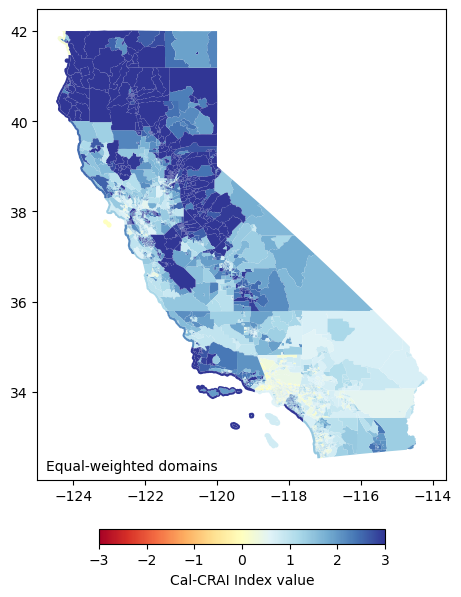

In [90]:
index_plot(df_eq)

To interpret these maps, a **positive** value indicates a high resilience score, while a **negative** value indicates a low resilience score. 

Now let's look at the input domains as well: 

In [101]:
def _domain_plot_weighting(df, society, built, natural):
    '''In order to visualize the importance of weighting each domain'''
    df['society_economy_tract_adjusted'] = df['society_economy_tract_adjusted'] * society
    df['built_tract_adjusted'] = df['built_tract_adjusted'] * built
    df['natural_tract_adjusted'] = df['natural_tract_adjusted'] * natural
    return df

def index_domain_plot(df, scenario=None, society=1, built=1, natural=1, save=False):
    '''Produces subplots of the Cal-CRAI index value and the corresponding domains'''
    # internally weight domains
    df = _domain_plot_weighting(df, society, built, natural)
    
    # plotting help
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

    # set-up figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(12,6), layout='compressed')
    vmin=-3
    vmax=3
    dmin=-1
    dmax=1
    cm='RdYlBu'

    df2.plot(ax=ax1, column='calcrai_score', vmin=vmin, vmax=vmax, legend=True, cmap=cm,
             legend_kwds={'label':'Cal-CRAI Index value', 'orientation': 'horizontal', 'shrink':0.7});
    df2.plot(ax=ax2, column='society_economy_tract_adjusted', vmin=dmin, vmax=dmax, legend=True, cmap=cm,
             legend_kwds={'label':'Society & Economy \ndomain weight', 'orientation': 'horizontal', 'shrink':0.7});
    df2.plot(ax=ax3, column='natural_tract_adjusted', vmin=dmin, vmax=dmax, legend=True, cmap=cm,
             legend_kwds={'label':'Natural Systems \ndomain weight', 'orientation': 'horizontal', 'shrink':0.7});
    df2.plot(ax=ax4, column='built_tract_adjusted', vmin=dmin, vmax=dmax, legend=True, cmap=cm,
             legend_kwds={'label':'Built Environment \ndomain weight', 'orientation': 'horizontal', 'shrink':0.7});

    if scenario == None:
        ax1.annotate('Equal-weighted domains'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')
    else: 
        ax1.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')

    if save:
        fig.savefig('ca_domains_map.png', dpi=300, bbox_inches='tight') ## need to replace fig name once data repo completed

In [96]:
df_eq

,GEOID,summed_indicators_governance_domain_min_max_standardized,summed_indicators_built_domain_min_max_standardized,summed_indicators_natural_domain_min_max_standardized,summed_indicators_society_economy_domain_min_max_standardized,built_median,governance_median,natural_median,society_economy_median,natural_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,crsi_top_equation,acute_risk,crsi_results,calcrai_weighted,calcrai_score
0,06001400100,0.471353,0.640031,0.417985,0.665240,0.545107,0.465803,0.539009,0.757574,-0.224531,-0.121881,0.174138,0.390152,0.491543,0.793728,0.390152,0.793728
1,06001400200,0.471353,0.588670,0.286363,0.658452,0.545107,0.465803,0.539009,0.757574,-0.468723,-0.130841,0.079916,0.226415,0.408514,0.554242,0.226415,0.554242
2,06001400300,0.471353,0.615958,0.681579,0.702919,0.545107,0.465803,0.539009,0.757574,0.264503,-0.072145,0.129976,0.623286,0.484127,1.287445,0.623286,1.287445
3,06001400400,0.471353,0.625081,0.669441,0.727820,0.545107,0.465803,0.539009,0.757574,0.241984,-0.039275,0.146712,0.636054,0.426125,1.492647,0.636054,1.492647
4,06001400500,0.471353,0.601230,0.618839,0.762025,0.545107,0.465803,0.539009,0.757574,0.148104,0.005876,0.102957,0.592461,0.441482,1.341983,0.592461,1.341983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.536479,0.744755,0.626012,0.700578,0.545107,0.465803,0.539009,0.757574,0.161412,-0.075234,0.366253,0.779198,0.200965,3.877279,0.779198,3.877279
9125,06115041001,0.536479,0.898643,0.629817,0.743486,0.545107,0.465803,0.539009,0.757574,0.168472,-0.018596,0.648561,0.964824,0.319781,3.017138,0.964824,3.017138
9126,06115041002,0.536479,0.803379,0.318477,0.745345,0.545107,0.465803,0.539009,0.757574,-0.409143,-0.016143,0.473799,0.562505,0.182173,3.087744,0.562505,3.087744
9127,06115041101,0.536479,0.887591,0.253372,0.768845,0.545107,0.465803,0.539009,0.757574,-0.529930,0.014878,0.628286,0.597227,0.188965,3.160507,0.597227,3.160507


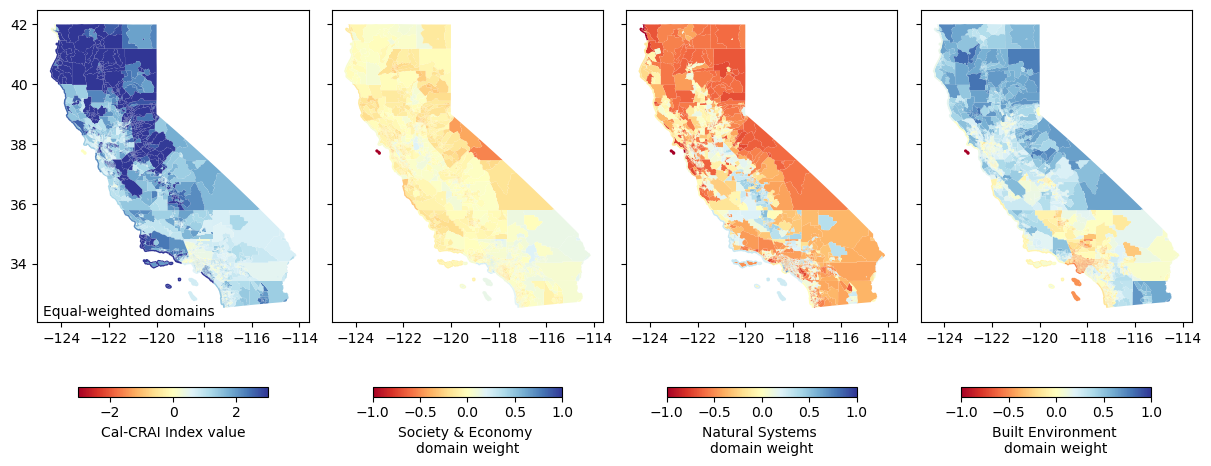

In [102]:
index_domain_plot(df_eq)